# Capstone Project — Hate Speech Detection
## Notebook 1: Exploratory Data Analysis (EDA)

**Dataset:** Davidson Hate Speech Dataset (labeled_data.csv)  
**Goal:** Understand the structure, class distribution, text patterns, and annotator agreement before modelling.

---

## 0. Setup — Import Libraries

In [41]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except ImportError:
    WORDCLOUD_AVAILABLE = False
    print('WordCloud not installed. Run: pip install wordcloud')

# Plot style
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'sans-serif'

# Class label mapping — we'll reuse this throughout
CLASS_LABELS = {0: 'Hate Speech', 1: 'Offensive', 2: 'Neither'}
CLASS_COLORS = {0: '#D62728', 1: '#FF7F0E', 2: '#2CA02C'}

print('Setup complete!')

Setup complete!


---
## 1. Load & Inspect the Data

In [25]:
# Load dataset — update the path if needed
df = pd.read_csv('labeled_data.csv')

# Drop unnamed index column
df = df.drop(columns=['Unnamed: 0'])

# Map class numbers to readable labels
df['class_label'] = df['class'].map(CLASS_LABELS)

print(f'Dataset shape: {df.shape}')
print(f'Columns: {df.columns.tolist()}')
df.head()

Dataset shape: (24783, 7)
Columns: ['count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet', 'class_label']


,count,hate_speech,offensive_language,neither,class,tweet,class_label
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,Neither
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,Offensive
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,Offensive
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,Offensive
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,Offensive


In [26]:
# Quick data quality check
print('--- Data Types ---')
print(df.dtypes)
print()
print('--- Missing Values ---')
print(df.isnull().sum())
print()
print('--- Duplicate Rows ---')
print(f'Duplicates: {df.duplicated().sum()}')

--- Data Types ---
count                  int64
hate_speech            int64
offensive_language     int64
neither                int64
class                  int64
tweet                 object
class_label           object
dtype: object

--- Missing Values ---
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
class_label           0
dtype: int64

--- Duplicate Rows ---
Duplicates: 0


In [27]:
# Column descriptions
# - count:              number of annotators who labeled this tweet
# - hate_speech:        how many annotators labeled it as hate speech
# - offensive_language: how many annotators labeled it as offensive
# - neither:            how many annotators labeled it as neither
# - class:              final majority-vote label (0=hate speech, 1=offensive, 2=neither)
# - tweet:              raw tweet text

print('Annotator count distribution:')
print(df['count'].value_counts().sort_index())

Annotator count distribution:
count
3    22807
4      211
6     1571
7       27
9      167
Name: count, dtype: int64


---
## 2. Class Distribution

Understanding how balanced (or imbalanced) the dataset is — this directly affects how we train our model.

In [28]:
class_counts = df['class'].value_counts().sort_index()
class_pct = (class_counts / len(df) * 100).round(1)

print('Class Distribution:')
for cls, name in CLASS_LABELS.items():
    print(f'  {name}: {class_counts[cls]:,} tweets ({class_pct[cls]}%)')

Class Distribution:
  Hate Speech: 1,430 tweets (5.8%)
  Offensive: 19,190 tweets (77.4%)
  Neither: 4,163 tweets (16.8%)


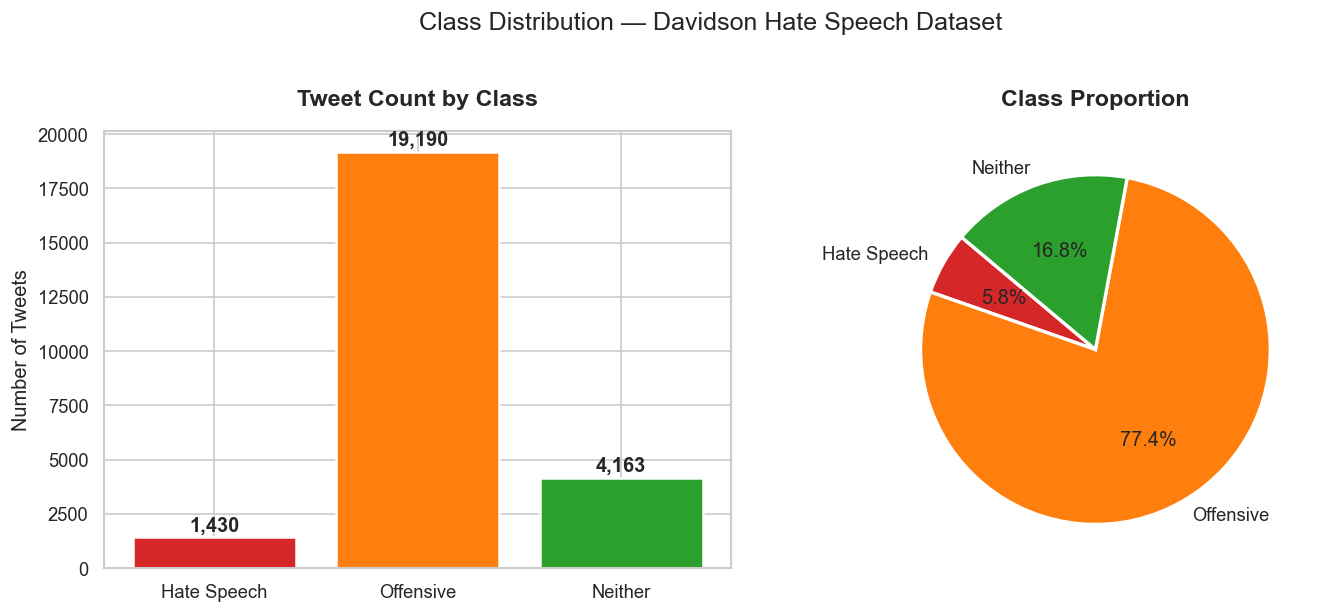

Saved: plot_01_class_distribution.png

KEY INSIGHT: The dataset is heavily imbalanced.
Offensive language (77.4%) dominates. Hate speech is only 5.8%.


In [42]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
colors = [CLASS_COLORS[i] for i in sorted(CLASS_LABELS.keys())]
bars = axes[0].bar(
    [CLASS_LABELS[i] for i in sorted(CLASS_LABELS.keys())],
    [class_counts[i] for i in sorted(CLASS_LABELS.keys())],
    color=colors, edgecolor='white', linewidth=1.5
)
axes[0].set_title('Tweet Count by Class', fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel('Number of Tweets')
for bar, count in zip(bars, [class_counts[i] for i in sorted(CLASS_LABELS.keys())]):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
                 f'{count:,}', ha='center', va='bottom', fontweight='bold')

# Pie chart
axes[1].pie(
    [class_counts[i] for i in sorted(CLASS_LABELS.keys())],
    labels=[CLASS_LABELS[i] for i in sorted(CLASS_LABELS.keys())],
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    wedgeprops={'edgecolor': 'white', 'linewidth': 2}
)
axes[1].set_title('Class Proportion', fontsize=14, fontweight='bold', pad=15)

plt.suptitle('Class Distribution — Davidson Hate Speech Dataset', fontsize=15, y=1.02)
plt.tight_layout()
plt.savefig('plot_01_class_distribution.png', bbox_inches='tight')
plt.show()
print('Saved: plot_01_class_distribution.png')

# KEY INSIGHT
print()
print('KEY INSIGHT: The dataset is heavily imbalanced.')
print('Offensive language (77.4%) dominates. Hate speech is only 5.8%.')


---
## 3. Annotator Agreement Analysis

Each tweet was labeled by multiple annotators. High agreement = cleaner label. Low agreement = ambiguous case.

In [30]:
# Agreement = max votes / total annotators for that tweet
df['agreement'] = df[['hate_speech', 'offensive_language', 'neither']].max(axis=1) / df['count']

print('Annotator Agreement Statistics:')
print(df['agreement'].describe().round(3))
print()
print(f"Perfect agreement (100%): {(df['agreement'] == 1.0).sum():,} tweets ({(df['agreement'] == 1.0).mean()*100:.1f}%)")
print(f"Low agreement (<67%): {(df['agreement'] < 0.67).sum():,} tweets ({(df['agreement'] < 0.67).mean()*100:.1f}%)")

Annotator Agreement Statistics:
count    24783.000
mean         0.905
std          0.149
min          0.444
25%          0.667
50%          1.000
75%          1.000
max          1.000
Name: agreement, dtype: float64

Perfect agreement (100%): 17,482 tweets (70.5%)
Low agreement (<67%): 6,733 tweets (27.2%)


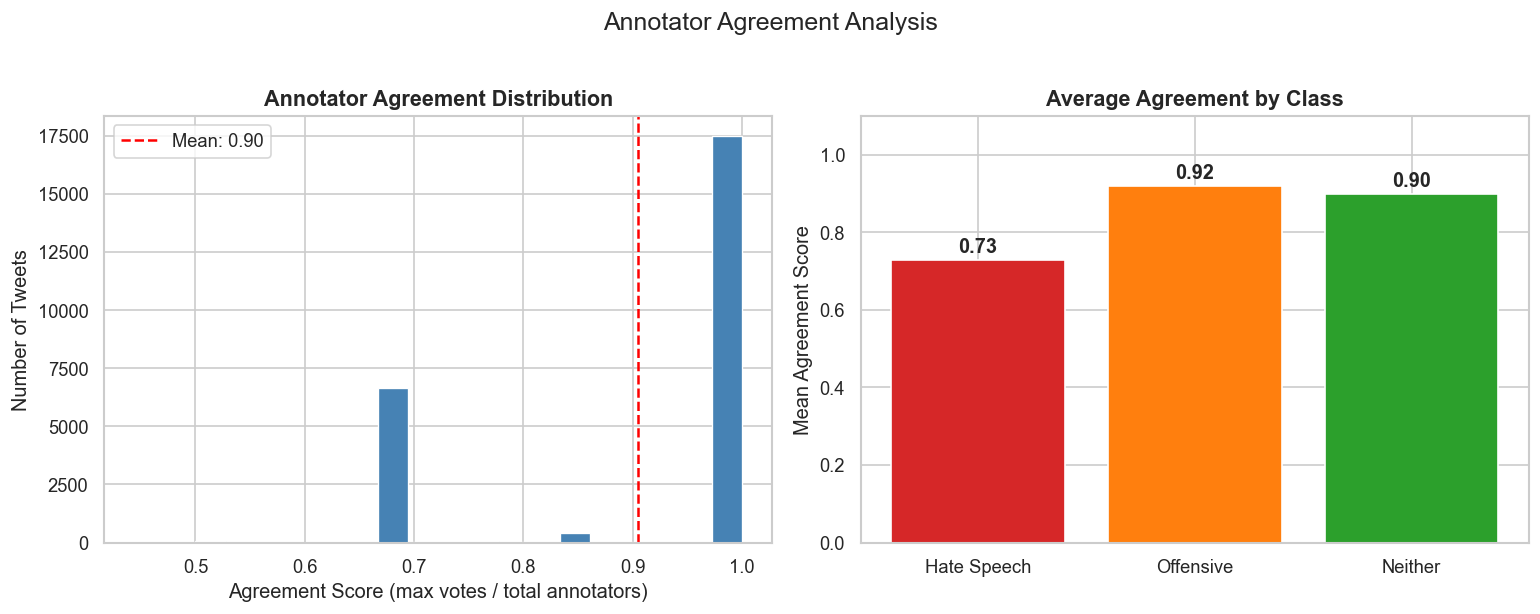

Saved: plot_02_annotator_agreement.png


In [31]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Agreement distribution overall
axes[0].hist(df['agreement'], bins=20, color='steelblue', edgecolor='white', linewidth=0.8)
axes[0].axvline(df['agreement'].mean(), color='red', linestyle='--', label=f"Mean: {df['agreement'].mean():.2f}")
axes[0].set_title('Annotator Agreement Distribution', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Agreement Score (max votes / total annotators)')
axes[0].set_ylabel('Number of Tweets')
axes[0].legend()

# Agreement by class
agreement_by_class = df.groupby('class_label')['agreement'].mean().reindex(['Hate Speech', 'Offensive', 'Neither'])
bar_colors = [CLASS_COLORS[0], CLASS_COLORS[1], CLASS_COLORS[2]]
bars = axes[1].bar(agreement_by_class.index, agreement_by_class.values, color=bar_colors, edgecolor='white')
axes[1].set_title('Average Agreement by Class', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Mean Agreement Score')
axes[1].set_ylim(0, 1.1)
for bar, val in zip(bars, agreement_by_class.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f'{val:.2f}', ha='center', fontweight='bold')

plt.suptitle('Annotator Agreement Analysis', fontsize=15, y=1.02)
plt.tight_layout()
plt.savefig('plot_02_annotator_agreement.png', bbox_inches='tight')
plt.show()
print('Saved: plot_02_annotator_agreement.png')

---
## 4. Text Length Analysis

Do hate speech tweets tend to be longer or shorter? Does tweet length carry a signal?

In [32]:
# Feature engineering: text length features
df['char_count'] = df['tweet'].str.len()
df['word_count'] = df['tweet'].str.split().str.len()
df['url_count'] = df['tweet'].str.count(r'http\S+')
df['mention_count'] = df['tweet'].str.count(r'@\w+')
df['hashtag_count'] = df['tweet'].str.count(r'#\w+')
df['exclamation_count'] = df['tweet'].str.count(r'!')

print('Text Feature Statistics by Class:')
df.groupby('class_label')[['char_count','word_count','mention_count','hashtag_count']].mean().round(2)

Text Feature Statistics by Class:


,char_count,word_count,mention_count,hashtag_count
class_label,,,,
Hate Speech,84.59,13.91,0.94,0.48
Neither,94.85,14.92,0.84,0.82
Offensive,83.46,13.96,0.75,0.79


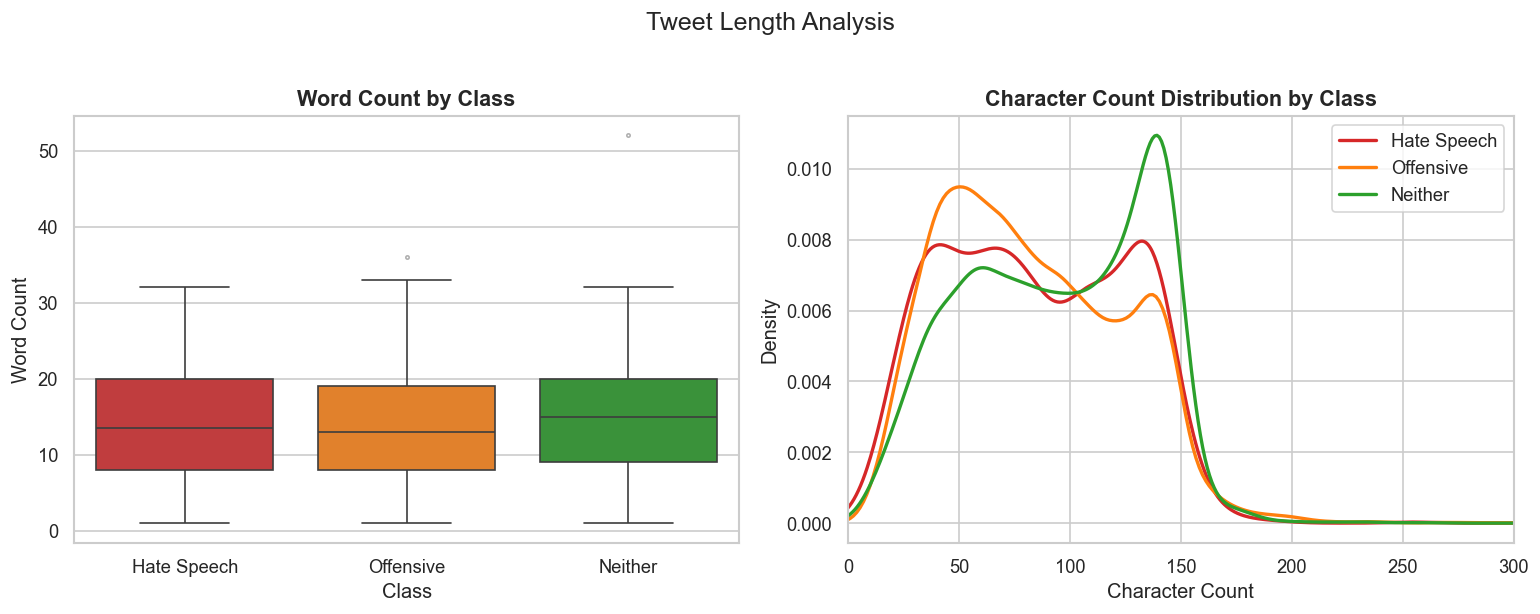

Saved: plot_03_text_length.png


In [33]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Word count by class — boxplot
class_order = ['Hate Speech', 'Offensive', 'Neither']
palette = {name: CLASS_COLORS[cls] for cls, name in CLASS_LABELS.items()}

sns.boxplot(
    data=df, x='class_label', y='word_count',
    order=class_order, palette=palette, ax=axes[0],
    flierprops={'marker': 'o', 'markersize': 2, 'alpha': 0.4}
)
axes[0].set_title('Word Count by Class', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Word Count')

# Character count distribution — KDE per class
for cls, name in CLASS_LABELS.items():
    subset = df[df['class'] == cls]['char_count']
    subset.plot.kde(ax=axes[1], label=name, color=CLASS_COLORS[cls], linewidth=2)
axes[1].set_title('Character Count Distribution by Class', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Character Count')
axes[1].set_xlim(0, 300)
axes[1].legend()

plt.suptitle('Tweet Length Analysis', fontsize=15, y=1.02)
plt.tight_layout()
plt.savefig('plot_03_text_length.png', bbox_inches='tight')
plt.show()
print('Saved: plot_03_text_length.png')

---
## 5. Twitter Feature Analysis

Mentions (@), hashtags (#), and URLs — do they differ between hate speech and other categories?

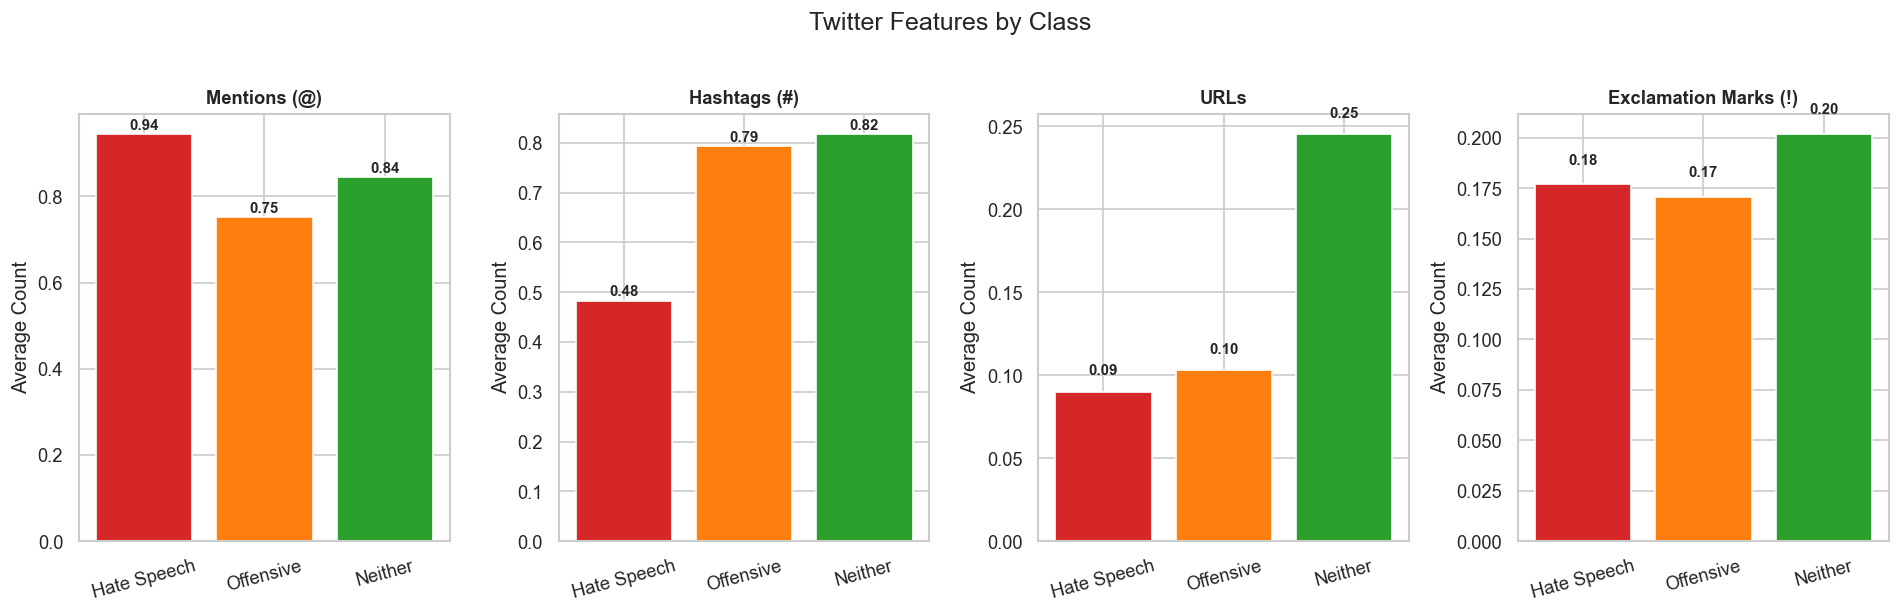

Saved: plot_04_twitter_features.png


In [34]:
features = ['mention_count', 'hashtag_count', 'url_count', 'exclamation_count']
feature_labels = ['Mentions (@)', 'Hashtags (#)', 'URLs', 'Exclamation Marks (!)']

fig, axes = plt.subplots(1, 4, figsize=(16, 5))

for ax, feat, label in zip(axes, features, feature_labels):
    means = df.groupby('class_label')[feat].mean().reindex(class_order)
    bars = ax.bar(class_order, means.values,
                  color=[CLASS_COLORS[0], CLASS_COLORS[1], CLASS_COLORS[2]],
                  edgecolor='white')
    ax.set_title(label, fontsize=11, fontweight='bold')
    ax.set_ylabel('Average Count')
    ax.tick_params(axis='x', rotation=15)
    for bar, val in zip(bars, means.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{val:.2f}', ha='center', fontsize=9, fontweight='bold')

plt.suptitle('Twitter Features by Class', fontsize=15, y=1.02)
plt.tight_layout()
plt.savefig('plot_04_twitter_features.png', bbox_inches='tight')
plt.show()
print('Saved: plot_04_twitter_features.png')

---
## 6. Word Cloud 


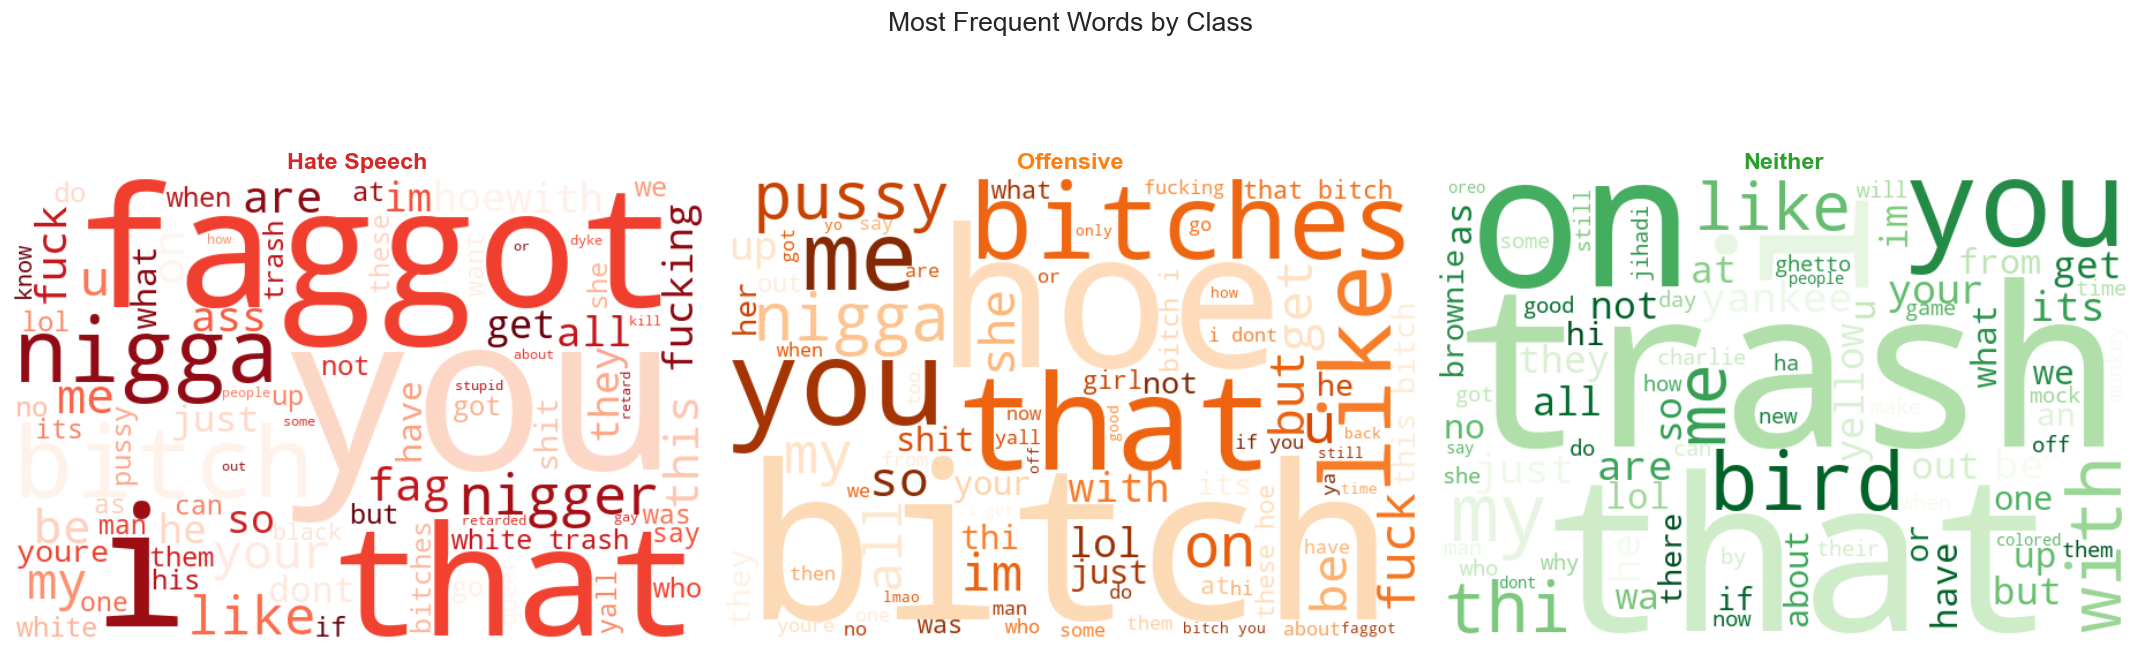

Saved: plot_05_wordclouds.png


In [39]:
def clean_text_for_wordcloud(text):
    """Basic cleaning: remove URLs, mentions, special characters."""
    text = re.sub(r'http\S+', '', text)       # remove URLs
    text = re.sub(r'@\w+', '', text)           # remove mentions
    text = re.sub(r'RT\s', '', text)           # remove RT prefix
    text = re.sub(r'[^a-zA-Z\s]', '', text)   # keep only letters
    text = text.lower().strip()
    return text

if WORDCLOUD_AVAILABLE:
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    wc_colors = ['Reds', 'Oranges', 'Greens']

    for ax, (cls, name), cmap in zip(axes, CLASS_LABELS.items(), wc_colors):
        text = ' '.join(df[df['class'] == cls]['tweet'].apply(clean_text_for_wordcloud))
        wc = WordCloud(
            width=600, height=400, background_color='white',
            colormap=cmap, max_words=80,
            stopwords={'rt', 'amp', 'the', 'a', 'to', 'is', 'it', 'in', 'of', 'and', 'for'}
        ).generate(text)
        ax.imshow(wc, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(name, fontsize=14, fontweight='bold', color=CLASS_COLORS[cls])

    plt.suptitle('Most Frequent Words by Class', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig('plot_05_wordclouds.png', bbox_inches='tight')
    plt.show()
    print('Saved: plot_05_wordclouds.png')
else:
    print('WordCloud not available. Install with: pip install wordcloud')

---
## 7. Correlation Heatmap

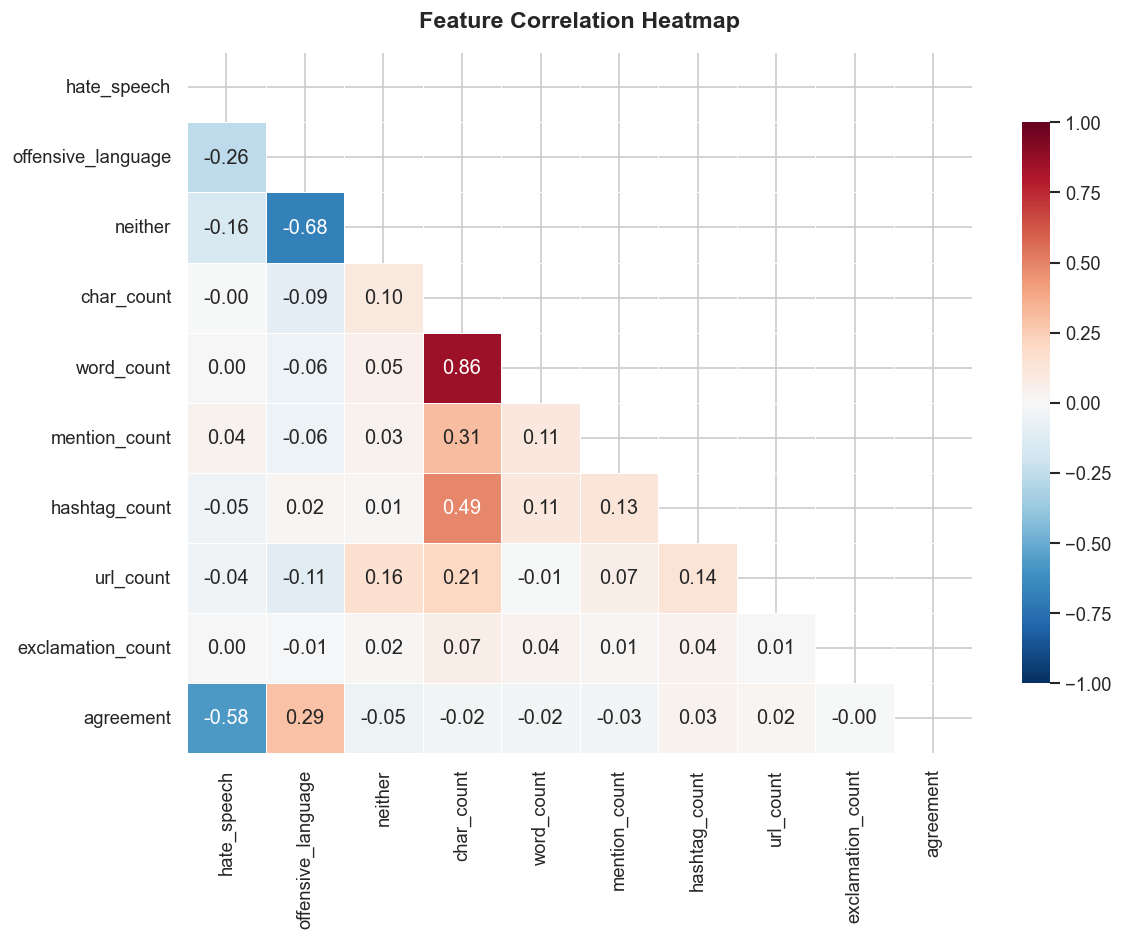

Saved: plot_06_correlation.png


In [36]:
numeric_cols = ['hate_speech', 'offensive_language', 'neither',
                'char_count', 'word_count', 'mention_count',
                'hashtag_count', 'url_count', 'exclamation_count', 'agreement']

corr = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(
    corr, mask=mask, annot=True, fmt='.2f',
    cmap='RdBu_r', center=0, vmin=-1, vmax=1,
    linewidths=0.5, ax=ax, cbar_kws={'shrink': 0.8}
)
ax.set_title('Feature Correlation Heatmap', fontsize=14, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig('plot_06_correlation.png', bbox_inches='tight')
plt.show()
print('Saved: plot_06_correlation.png')

---
## 8. EDA Summary & Key Insights

A summary of what we found before moving to the NLP pipeline.

In [37]:
print('=' * 60)
print('EDA SUMMARY — KEY INSIGHTS')
print('=' * 60)
print()
print(f'Total tweets: {len(df):,}')
print(f'No missing values or duplicates found.')
print()
print('1. CLASS IMBALANCE')
print('   Offensive language dominates (77.4%).')
print('   Hate speech is a minority class (5.8%).')
print('   => Use class_weight="balanced" in models or oversample.')
print()
print('2. HIGH ANNOTATOR AGREEMENT')
print(f"   Mean agreement: {df['agreement'].mean():.2f}")
print(f"   {(df['agreement'] == 1.0).mean()*100:.1f}% of tweets have perfect unanimous labels.")
print('   => Labels are reliable. Low noise dataset.')
print()
print('3. TEXT LENGTH')
print(f"   Mean word count: {df['word_count'].mean():.1f} words")
print(f"   Hate speech tweets are slightly shorter on average.")
print('   => Word/char count may be a weak but useful feature.')
print()
print('4. TWITTER FEATURES')
print('   Hate speech has more mentions (@) and fewer URLs.')
print('   => Structural features can complement text features.')
print()
print('NEXT STEP: 02_nlp_pipeline.ipynb')
print('  - Text preprocessing (clean tweets)')
print('  - Topic modelling with BERTopic')
print('  - Toxicity scoring with HuggingFace')
print('  - Value sentiment analysis')

EDA SUMMARY — KEY INSIGHTS

Total tweets: 24,783
No missing values or duplicates found.

1. CLASS IMBALANCE
   Offensive language dominates (77.4%).
   Hate speech is a minority class (5.8%).
   => Use class_weight="balanced" in models or oversample.

2. HIGH ANNOTATOR AGREEMENT
   Mean agreement: 0.90
   70.5% of tweets have perfect unanimous labels.
   => Labels are reliable. Low noise dataset.

3. TEXT LENGTH
   Mean word count: 14.1 words
   Hate speech tweets are slightly shorter on average.
   => Word/char count may be a weak but useful feature.

4. TWITTER FEATURES
   Hate speech has more mentions (@) and fewer URLs.
   => Structural features can complement text features.

NEXT STEP: 02_nlp_pipeline.ipynb
  - Text preprocessing (clean tweets)
  - Topic modelling with BERTopic
  - Toxicity scoring with HuggingFace
  - Value sentiment analysis


In [38]:
# Save the enriched dataset for the next notebook
df.to_csv('labeled_data_eda.csv', index=False)
print('Saved enriched dataset: labeled_data_eda.csv')
print('This file includes the new features: char_count, word_count, agreement, etc.')

Saved enriched dataset: labeled_data_eda.csv
This file includes the new features: char_count, word_count, agreement, etc.
